In [290]:
#Dawn Schmidt
#Machine Learning II
#August 5, 2024
#Assignment 2

# Data Loading and pre processing

In [287]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.metrics import mean_squared_error
import numpy as np

#load the data
df = pd.read_csv('data_assignment2.csv', index_col=0)

#convert the 'Year_Month' column to datetime format and extract the month
df['Year_Month'] = pd.to_datetime(df['Year_Month'], format='%Y-%m')
df['Month'] = df['Year_Month'].dt.month

#encode the categorical variables
label_encoders = {}
for column in ['Country', 'FoodItem', 'Quality']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le


# Cross Validation and model eval

In [285]:
#identify features and target variable
X = df[['Country', 'FoodItem', 'Availability', 'Quality', 'Month']]
y = df['PriceinUSD']

#TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

#test models Random Forest, GradientboostingRegressor
models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'poly_SVM': make_pipeline(StandardScaler(), SVR(kernel='poly')),
    'RBF_SVM': make_pipeline(StandardScaler(), SVR(kernel='rbf'))
}

#cross-validation with different models
cv_results = {}
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
    mse_scores = -scores # Convert to positive MSE values
    cv_results[name] = mse_scores
    results[name] = mse_scores.mean()

#convert results to data frame
average_mse_df = pd.DataFrame(list(results.items()), columns=['Model', 'Average MSE'])
cv_results_df = pd.DataFrame(cv_results)
print(average_mse_df)
print(cv_results_df)


                       Model  Average MSE
0      RandomForestRegressor     0.346088
1  GradientBoostingRegressor     0.309078
2                   poly_SVM     0.513583
3                    RBF_SVM     0.407480
   RandomForestRegressor  GradientBoostingRegressor  poly_SVM   RBF_SVM
0               0.114650                   0.113688  0.414735  0.379108
1               0.538788                   0.533348  0.276915  0.212018
2               0.470070                   0.421453  0.179990  0.666423
3               0.277733                   0.235094  0.979407  0.344791
4               0.329197                   0.241806  0.716867  0.435058


# Hyperparameter Tuning with GridSearchCV

In [283]:
#define pipelines with models and standard scaler
pipeline_rf = make_pipeline(StandardScaler(), RandomForestRegressor())
pipeline_gb = make_pipeline(StandardScaler(), GradientBoostingRegressor())

#define hyperparameters for tuning
param_grid_rf = {
    'randomforestregressor__n_estimators': [50, 100],
    'randomforestregressor__max_depth': [3, 5]
}

param_grid_gb = {
    'gradientboostingregressor__n_estimators': [50, 100],
    'gradientboostingregressor__max_depth': [3, 5],
    'gradientboostingregressor__learning_rate': [0.01, 0.1]
}

#grid search with TimeSeriesSplit
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=tscv, scoring='neg_mean_squared_error', return_train_score=True)
grid_search_rf.fit(X, y)

grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=tscv, scoring='neg_mean_squared_error', return_train_score=True)
grid_search_gb.fit(X, y)

#combine results from both grid searches
results_rf = pd.DataFrame(grid_search_rf.cv_results_)
results_gb = pd.DataFrame(grid_search_gb.cv_results_)

#add a column to identify the model
results_rf['Model'] = 'RandomForest'
results_gb['Model'] = 'GradientBoosting'

#concat the results
combined_results = pd.concat([results_rf, results_gb], axis=0)


# Visualization of hyperparameter tuning results

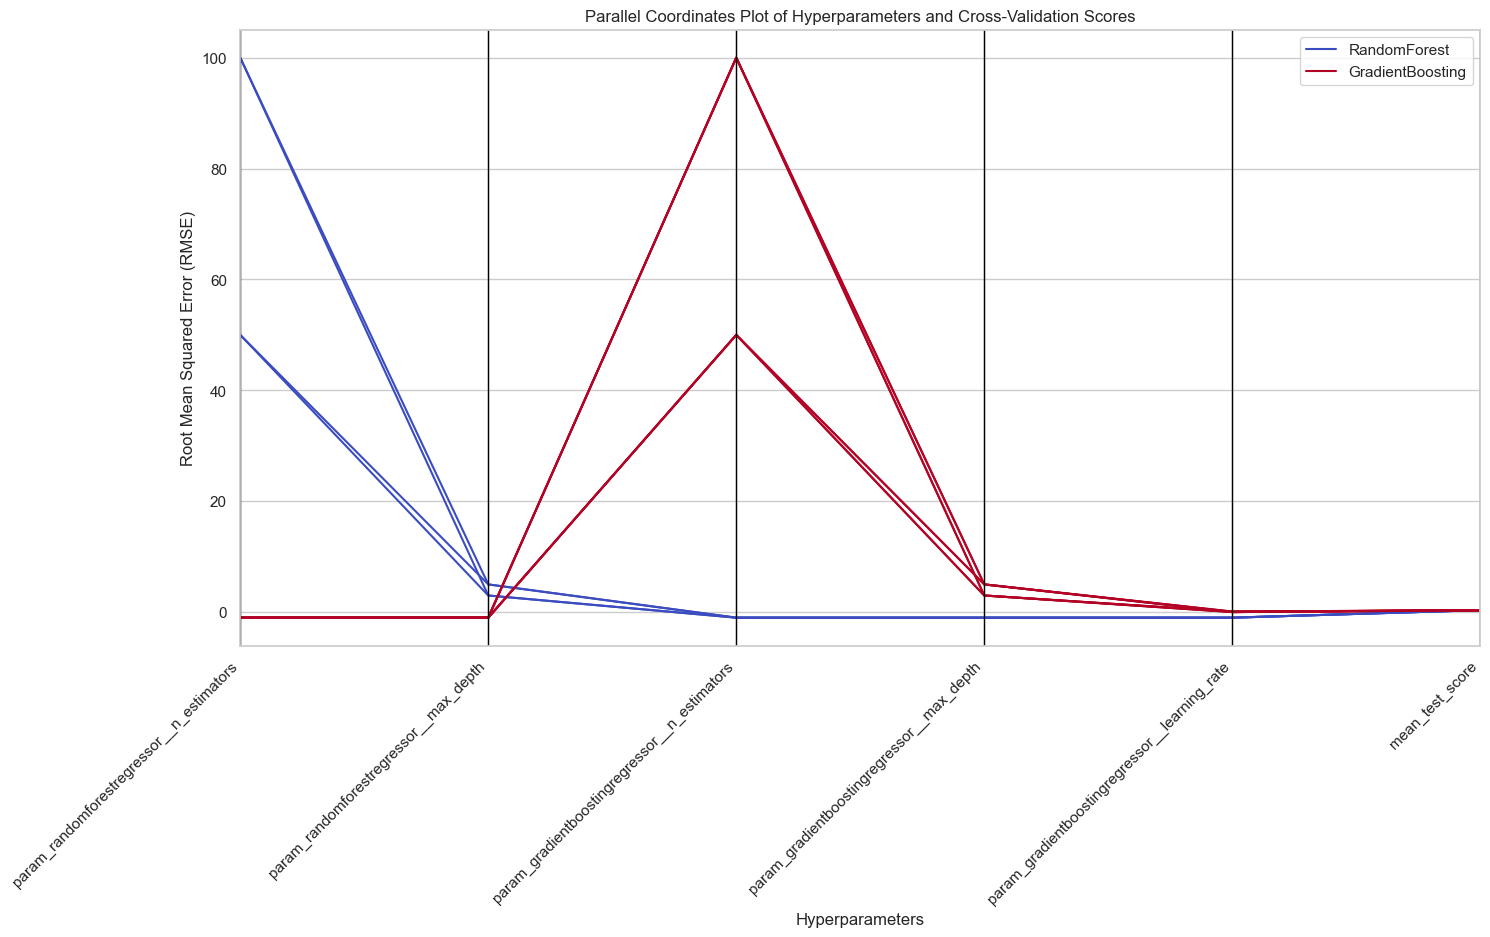

In [264]:
#combined parallel coordinates plot for random forest and gradient boosting
#select relevant columns and fill Nas with a placeholder (-1) to make the plot
plot_data = combined_results[[
    'param_randomforestregressor__n_estimators',
    'param_randomforestregressor__max_depth',
    'param_gradientboostingregressor__n_estimators',
    'param_gradientboostingregressor__max_depth',
    'param_gradientboostingregressor__learning_rate',
    'mean_test_score',
    'Model'
]].fillna(-1)

#convert negative mean_test_score to positive for RMSE
plot_data['mean_test_score'] = -plot_data['mean_test_score']

#generate the parallel coordinates plot
plt.figure(figsize=(16, 8))
parallel_coordinates(plot_data, class_column='Model', colormap='coolwarm')
plt.title('Parallel Coordinates Plot of Hyperparameters and Cross-Validation Scores')
plt.xlabel('Hyperparameters')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

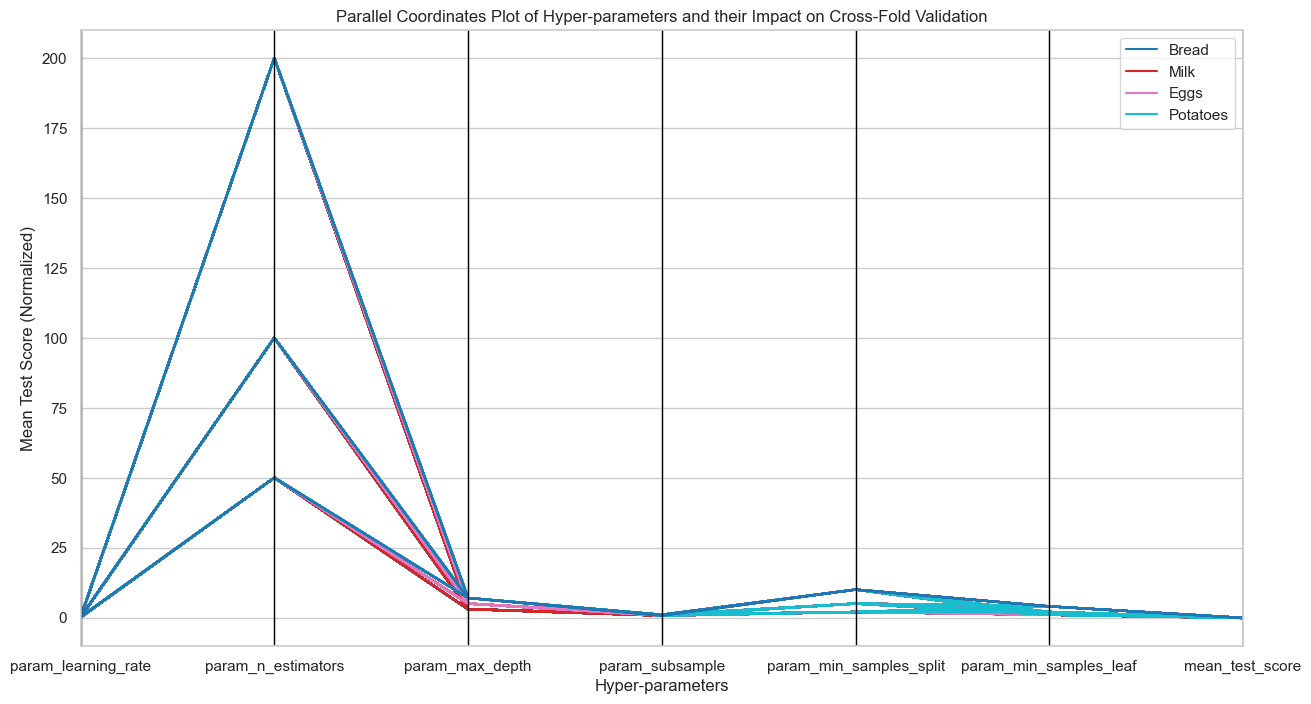

In [280]:
#map the codes to the original names
def safe_inverse_transform(x):
    try:
        return label_encoders['FoodItem'].inverse_transform([x])[0]
    except ValueError:
        return x  # Return the original value if it cannot be transformed

#apply the safe inverse transform
results_df['FoodItem'] = results_df['FoodItem'].apply(safe_inverse_transform)

#plot the parallel coordinates plot with 'FoodItem' as the identifier
plt.figure(figsize=(15, 8))
parallel_coordinates(results_df[columns_to_plot + ['FoodItem']], 'FoodItem', colormap=plt.get_cmap("tab10"))
plt.title('Parallel Coordinates Plot of Hyper-parameters and their Impact on Cross-Fold Validation')
plt.xlabel('Hyper-parameters')
plt.ylabel('Mean Test Score (Normalized)')
plt.grid(True)
plt.show()

# Comparing Test Errors with Different Gaps

In [233]:
#compare TimeSeriesSplit with gap=0 and gap=2 for each model (gradient boosting, RBF SVM, Poly SVM, Random Forest)
#identify features and target variable
X = df[['Country', 'FoodItem', 'Availability', 'Quality', 'Month']]
y = df['PriceinUSD']

#TimeSeriesSplit with gap=2 and gap=0
gaps = [2, 0]
mse_results = []

for gap in gaps:
    tscv = TimeSeriesSplit(n_splits=5, gap=gap)
    
    for model_name, model in models.items():
        test_errors = []
        
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            #calculate test MSE
            test_mse = mean_squared_error(y_test, y_pred)
            test_errors.append(test_mse)
        
        #store the mean test MSE for this model and gap
        mse_results.append({'Model': model_name, 'Gap': gap, 'Mean_Test_MSE': np.mean(test_errors)})

#convert the results to a data frame
mse_results_df = pd.DataFrame(mse_results)

#pivot the data frame to create a comparison table for gap=0 and gap=2
comparison_table = mse_results_df.pivot(index='Model', columns='Gap', values='Mean_Test_MSE')

#calculate change from 0 to 2 gap and indicate increase or descrease
comparison_table['Change'] = comparison_table[2] - comparison_table[0]
comparison_table['Change_Indicator'] = comparison_table['Change'].apply(lambda x: 'Increased MSE' if x > 0 else 'Decreased MSE')

#display comparison table
print(comparison_table)


Gap                               0         2    Change Change_Indicator
Model                                                                   
GradientBoostingRegressor  0.309078  0.314359  0.005281    Increased MSE
RBF_SVM                    0.407480  0.409176  0.001696    Increased MSE
RandomForestRegressor      0.344138  0.344943  0.000805    Increased MSE
poly_SVM                   0.513583  0.512007 -0.001575    Decreased MSE


# Classifying products into 2 buckets based on price behavior

In [262]:
#pivot the data to have countries as columns and prices as values for each product
pivot_df = df.pivot_table(index='Year_Month', columns=['Country', 'FoodItem'], values='PriceinUSD')

#calculate the percentage change in prices over time for each country and product
price_changes = pivot_df.pct_change().dropna()

#empty dictionaries to store the correlation and variance results
product_correlation = {}
product_variance = {}

#loop through each product to calculate correlation and variance across countries
for product in df['FoodItem'].unique():
    #extract price changes for the product across different countries
    product_changes = price_changes.xs(product, level='FoodItem', axis=1)
    
    #calculate the average correlation of price changes across countries
    correlation_matrix = product_changes.corr()
    avg_correlation = correlation_matrix.mean().mean()
    
    #calculate the variance in price changes across countries
    variance_across_countries = product_changes.var().mean()
    
    #store the results
    product_correlation[product] = avg_correlation
    product_variance[product] = variance_across_countries

#convert the results to data frames
correlation_df = pd.DataFrame.from_dict(product_correlation, orient='index', columns=['Avg_Correlation'])
variance_df = pd.DataFrame.from_dict(product_variance, orient='index', columns=['Avg_Variance'])

#define thresholds for classification
threshold_correlation = correlation_df['Avg_Correlation'].mean()
threshold_variance = variance_df['Avg_Variance'].mean()

#classify products into two buckets based on correlation and variance
bucket1 = correlation_df[(correlation_df['Avg_Correlation'] >= threshold_correlation) & 
                         (variance_df['Avg_Variance'] <= threshold_variance)].index.tolist()

bucket2 = correlation_df[(correlation_df['Avg_Correlation'] < threshold_correlation) | 
                         (variance_df['Avg_Variance'] > threshold_variance)].index.tolist()

#use the LabelEncoder to map the product codes back to names
product_labels = {i: name for i, name in enumerate(label_encoders['FoodItem'].classes_)}

#convert bucket labels to product names
bucket1_names = [product_labels[code] for code in bucket1]
bucket2_names = [product_labels[code] for code in bucket2]

bucket1_names, bucket2_names

(['Bread', 'Potatoes'], ['Milk', 'Eggs'])